**Monthly Schedule (6 pts)**: Add a parameter `monthly_km` to the `simulate()` function, that is a list of monthly km targets. Convert this info in an average km goal per truck per hour per month and use this list to dynamically set the km driven depending on the month. Compare these two schedules for the base truck fleet and one with an optimizied schedule:
    - `[57800, 51850, 56100,	53550,	55250,	54400,	54400,	52700,	51000,	57800,	55250,	57800]`
    - `[36750,	39000,	70100,	69000,	78700,	65100,	75200,	66000,	69400,	64500,	60000,	35200]`


In [1]:
###~~~~~~~~~~~~~~~~~~~~~~~~
# Base model functionality
###~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
import pandas as pd
import Model as m
import matplotlib.pyplot as plt
###~~~~~~~~~~~~~~~~~~~~~~~~

# Result_pvb for simulate_pvb():
class Result_pvb:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0.19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption from "PV to Grid" to "PV to Truck" >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])

    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string
    
#> 1) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulaion pv, battery and grid included >
def simulate_pvb(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [2]:
# "Convert this info in an average km goal per truck per hour per month and use this list to..."
# dynamically set the km driven depending on the month

# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# amount of work hours per month of a "workday" truck
wdhh = (24-3)*5*4*5  # working hours a day * working day * number of weeks a month * 5 "workday" trucks

# amount of work hours per month for a "worknight" truck
wnhh = (24-12)*5*4*2  # working hours a day * working day * number of weeks a month * 2 "worknight" trucks

# "daytime"
dth = (24-3)*7*4

# "nighttime"
nth = (24-12)*7*4

# "evening"
evh = (24-3)*5*4

# "lunchbreak"
lbh = (24-(6+5))*7*4

ft = [str(a) for a in fleet_trucks]

wdh = (24-3)*5*4*np.sum(["workday" in a for a in ft])
wnh = (24-12)*5*4*np.sum(["worknight" in a for a in ft])
dth = (24-3)*7*4*np.sum(["daytime" in a for a in ft])
nth = (24-12)*7*4*np.sum(["nighttime" in a for a in ft])
evh = (24-3)*5*4*np.sum(["evening" in a for a in ft])
lbh = (24-(6+5))*7*4*np.sum(["lunchbreak" in a for a in ft])

# checking
avg_km = 36750/(wdh+wnh+dth+nth+evh+lbh)
avg_km

avg_kmm = 36750/(wdhh+wnhh)
avg_kmm == avg_km

True

In [3]:
# add monthly_km hidden (inside the function) parameter via list_monthly_km parameter to simulate_pvb()
def simulate_pvbm(
        csv_dpath = "D:\SimMod_E-Post\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        list_monthly_km = list,                   # added 
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                   # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()
        mo = i.month                          # added iterative month 

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                
                # select appropiate month (use iterative mo = i.month)              # added monthly_km
                monthly_km = list_monthly_km[mo-1]
                # dynamic avg_km_per_h                                              
                ft = [str(a) for a in trucks]

                wdh = (24-3)*5*4*np.sum(["workday" in a for a in ft])
                wnh = (24-12)*5*4*np.sum(["worknight" in a for a in ft])
                dth = (24-3)*7*4*np.sum(["daytime" in a for a in ft])
                nth = (24-12)*7*4*np.sum(["nighttime" in a for a in ft])
                evh = (24-3)*5*4*np.sum(["evening" in a for a in ft])
                lbh = (24-(6+5))*7*4*np.sum(["lunchbreak" in a for a in ft])

                avg_km = monthly_km/(wdh+wnh+dth+nth+evh+lbh)
                truck.avg_km_per_h = avg_km
                # until here
                
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [4]:
# base truck fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# optimized truck fleet
fleet_opti_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 6), 
                                    np.repeat([m.Etruck(schedule="evening")], 1))).tolist()

# Compare these two schedules for the
# base truck fleet and one with an optimizied schedule:
km1 = [57800, 51850, 56100, 53550, 55250, 54400, 54400, 52700, 51000, 57800, 55250, 57800]
km2 = [36750, 39000, 70100, 69000, 78700, 65100, 75200, 66000, 69400, 64500, 60000, 35200]

# simulate base truck leet
msim_base_km1 = simulate_pvbm(trucks=fleet_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km1)
msim_base_km2 = simulate_pvbm(trucks=fleet_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km2)

# simulate optimized truck fleet
msim_opti_km1 = simulate_pvbm(trucks=fleet_opti_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km1)
msim_opti_km2 = simulate_pvbm(trucks=fleet_opti_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km2)


Energy Flows: 
Grid                 16796.0
PV to Truck          51265.0
PV to Battery       105120.0
PV to Grid           51284.0
Battery to Truck    105120.0
Grid to Truck        16796.0
Driven             -173981.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=750_000.0€
self.operating_cost=477_747.9€/a
self.emissions=4535.0kg/a
self.self_consumption=0.8kWh
self.total_cost=5_527_478.9€/10a
self.load_cycles=70kwh

Total Battery Charge: 105119.74 kWh
Total Battery Discharge: 105119.74 kWh
>>>> ___Battery charge < Battery Discharge___ <<<<

Total Energy Input: 173181.33 kWh
Total Energy Output from Trucks: 173981.33 kWh
>>>> ___Energy Input < Energy Output___ <<<<

Energy Flows: 
Grid                 15762.0
PV to Truck          53757.0
PV to Battery       108418.0
PV to Grid           45495.0
Battery to Truck    108418.0
Grid to Truck        15762.0
Driven             -177893.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=750_000.0€
self.operating_cost=466_896.2€/a
se

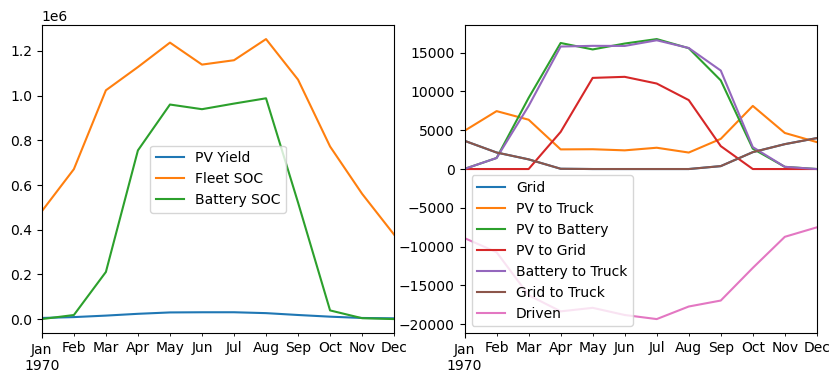

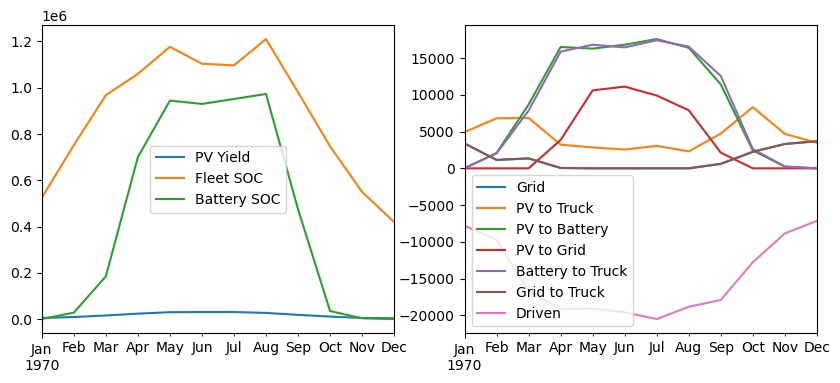

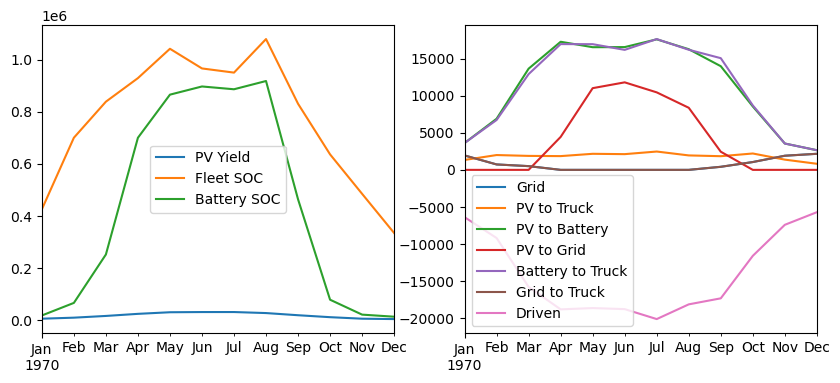

In [5]:
# print and visualize
print(msim_base_km1)
msim_base_km1.visualize(("M", "M"))
print(msim_base_km2)
msim_base_km2.visualize(("M", "M"))
print(msim_opti_km2)
msim_opti_km2.visualize(("M", "M"))

***AnSWERs***: 
- Unexpectedly, there can be observed almost no differences between 'km1' and 'km2' base models. As shown above, their similarities are highlighted quantitatively and graphically as well (top and middle figures).
- Regarding the optimized model (note that only the 'km2' model was considered) (bottom figure), it revealed a total cost of 1858664.8 €/10a which is less than the half of the base models, 5782478.9 and 5593962.4 €/10a respectively. Thus, it is safe to conclude that our optimized model is well-optimized.
- -> Overall, the effects of the two varying km per h per month lists ~ as compared to each other ~, are negligible. The optimized model outperforms the base models. It is not necessary to check 'km1' with optimized model, since it is very likely similar to the optimized model using 'km2' list. -> Let's not let curiosity kill the cat, let's quickly plot it below.

Energy Flows: 
Grid                  8625.0
PV to Truck          20691.0
PV to Battery       126387.0
PV to Grid           60591.0
Battery to Truck    126387.0
Grid to Truck         8625.0
Driven             -156490.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=750_000.0€
self.operating_cost=3_496.3€/a
self.emissions=2328.9kg/a
self.self_consumption=0.9kWh
self.total_cost=784_962.8€/10a
self.load_cycles=84kwh

Total Battery Charge: 126387.22 kWh
Total Battery Discharge: 126387.22 kWh
>>>> ___Battery charge > Battery Discharge___ <<<<

Total Energy Input: 155703.55 kWh
Total Energy Output from Trucks: 156490.39 kWh
>>>> ___Energy Input < Energy Output___ <<<<



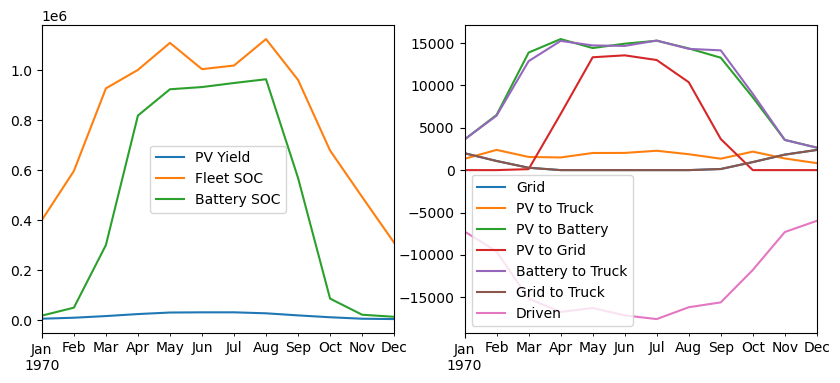

In [6]:
print(msim_opti_km1)
msim_opti_km1.visualize(("M", "M"))

In [7]:
print(f"Standarad deviation of 'km1': {round(np.std(km1), 0)}")
print(f"Standarad deviation of 'km2': {round(np.std(km2), 0)}")

Standarad deviation of 'km1': 2208.0
Standarad deviation of 'km2': 14504.0


***CONCLUSIONs***: 
- Well, we were wrong, Battery SOC is closer to the Fleet SOC! Moreover, the 'km1' optimised model reduced the total cost to 959962.8 €/10a, to the half of the total cost obtained by 'km2' optimized model. 
- -> Once the parameter set optimized, it DOES MATTER how average km goal per truck per hour per month  is distributed over the months of year. Since 'km1' evidences much less standard deviation, 2208 vs. 14504 km, it is recommended to keep the target km per month (accordingly the obtained average km goal per truck per hour) steady, close to the mean, with not much standard deviation (variabilty).